In [ ]:
import xgboost as xgb
import shap
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

from DataFields import DateReportedFields
from ProjectFunctions import one_hot_encode_vascular_problems, convert_date_to_binary

#### Create XGB dataset

In [2]:
df_diagnosed = pd.read_csv("diagnosed_processed.csv")
df_undiagnosed = pd.read_csv("undiagnosed.csv")

df_merged = pd.concat([df_diagnosed, df_undiagnosed], ignore_index=True, sort=False)

df_merged = one_hot_encode_vascular_problems(df_merged)
df_merged = df_merged.drop(columns=["Education"]) # columns to exclude, if wanted 

df_merged = convert_date_to_binary(df_merged, DateReportedFields)

# split to test and train
X = df_merged.drop('Vascular Dementia Report Date', axis=1)  # Features
y = df_merged['Vascular Dementia Report Date']  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#### Create XGB classifier

In [3]:
xgb_model = xgb.XGBClassifier(eval_metric='logloss')
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

Accuracy: 0.9391812865497076
ROC AUC Score: 0.9656729653390554


#### Plot ROC Curve

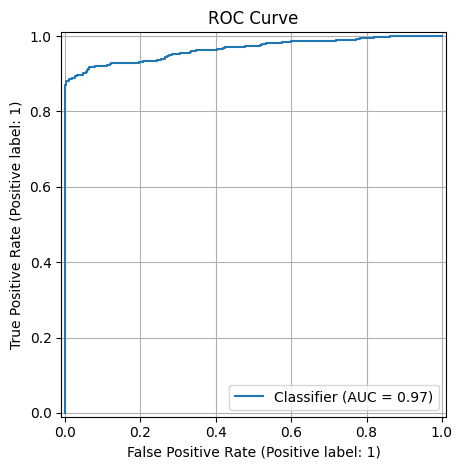

In [4]:
RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title("ROC Curve")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Plot Confusion Matrix

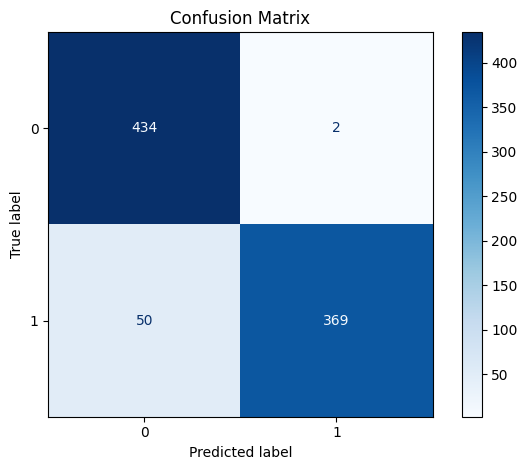

In [5]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

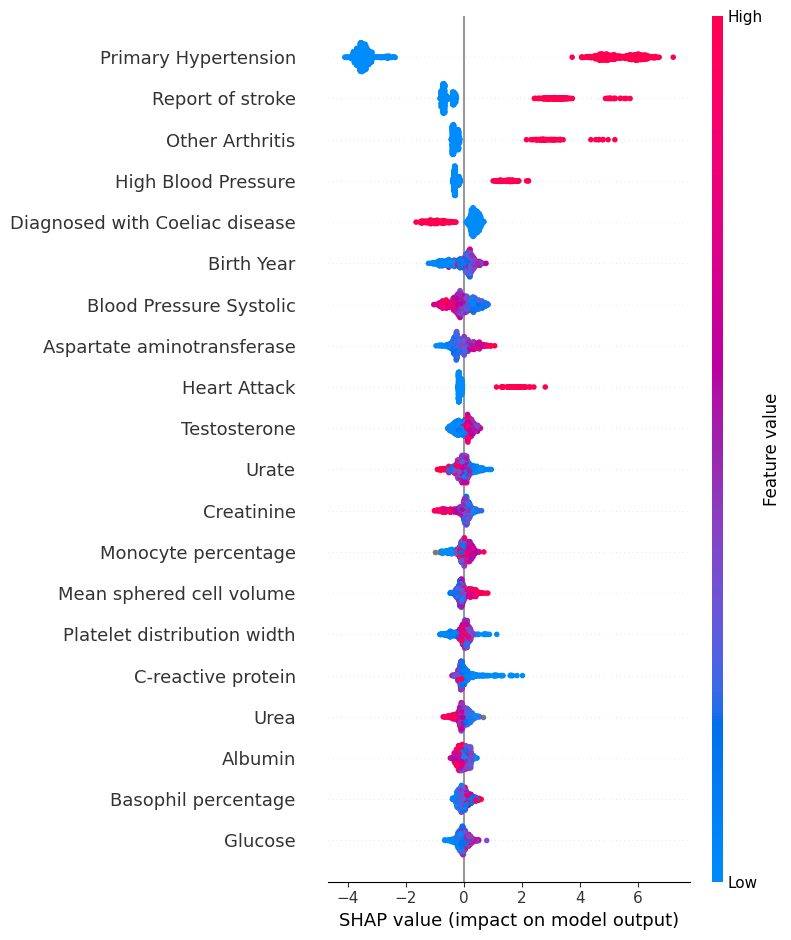

In [6]:
explainer = shap.Explainer(xgb_model, X_train, feature_names=X_train.columns)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)